## Gothic NCEP Reanalysis Data Download

In [1]:
import ftplib
import urllib.request
import io
import warnings
import datetime as dt

import numpy as np
import xarray as xr
import geopandas as gpd

import act 

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import holoviews as hv 
import geoviews as gv
import hvplot.xarray
import hvplot.pandas
import panel as pn
import panel.widgets as pnw

from shapely.errors import ShapelyDeprecationWarning
import xmovie
from xmovie import Movie


warnings.filterwarnings(
    action='ignore',
    category=ShapelyDeprecationWarning,  # in cartopy
)
warnings.filterwarnings(
    action="ignore",
    category=UserWarning,
    message=r"No `(vmin|vmax)` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `\1` to avoid this step"
)

hv.extension('bokeh')
from bokeh.plotting import show


TypeError: '<' not supported between instances of 'Version' and 'str'

In [2]:
state_url = 'https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json'
states_gdf = gpd.read_file(state_url)
west_gdf = states_gdf[states_gdf['NAME'].isin(['Washington','Colorado', 'Utah', 'Wyoming', 'Texas', 'Idaho', 'Arizona', 'Oregon', 'California'])]

In [3]:
bounds = west_gdf.dissolve().geometry.total_bounds
west_coords = {'xmin':bounds[0]-2, 'ymin':bounds[1], 'xmax':bounds[2]+2, 'ymax': bounds[3]+2}

### Pull in different files

In [4]:
def ncep_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login
    ftp.cwd(f'./Datasets/ncep.reanalysis/{product}/')
    
    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out pressure files that I'm interested in
    product_files = []
    for file in files:
        if (f'{product_code}.{start_year}' in file) or (f'{product_code}.{end_year}' in file):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            print(f'Filtering {file}...')
            # Transform coordiantes
            ds.coords['lon'] = ds.coords['lon'] - 180
            # Filter to western US
            ds = ds.sel(lat=slice(coords['ymax'], coords['ymin']), lon=slice(coords['xmin'], coords['xmax']))
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [51]:
xds_pressure = ncep_reanalysis_dynamic_load('pressure', product_code='hgt', start_year=2016, end_year=2017, coords=west_coords,
                                            first_yr_start_date='2016-10-1',first_yr_end_date='2016-12-31')

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching hgt.2016.nc...
Filtering hgt.2016.nc...
Done!
Fetching hgt.2017.nc...
Filtering hgt.2017.nc...
Done!


<AxesSubplot:xlabel='lon', ylabel='Latitude [degrees_north]'>

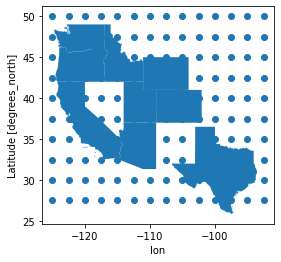

In [ ]:
# Visualize the area that we will be covering
fig,ax = plt.subplots()
xds_pressure.plot.scatter(x="lon", y='lat', ax=ax)
west_gdf.plot(ax=ax)

### Pull in the long term mean data (1991-2020)

In [52]:
ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
ftp.login() # Anonymous login
ftp.cwd('./Datasets/ncep.reanalysis.derived/pressure/')

derived_files = ftp.nlst() # Collect files into vector
ftp.close()

mean_pressure_file = 'hgt.day.ltm.1991-2020.nc'

# add long term 4x per day mean pressure file
longterm_mean_url = 'ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/' + mean_pressure_file

req = urllib.request.Request(longterm_mean_url)

with urllib.request.urlopen(req) as resp:
    ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')

longterm_mean_url = 'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/hgt.4Xday.1981-2010.ltm.nc'
req = urllib.request.Request(longterm_mean_url)

with urllib.request.urlopen(req) as resp:
    ds_mean = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
    # Transform coordiantes
    ds_mean.coords['lon'] = ds_mean.coords['lon'] - 180
            # Filter to western US
    ds_mean = ds_mean.sel(lat=slice(west_coords['ymax'], west_coords['ymin']), lon=slice(west_coords['xmin'], west_coords['xmax']))

/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/dlhogan/.conda/envs/act_env/lib/pyth

In [53]:
# convert dummy dates to fractional day of year
ds_mean = ds_mean.assign_coords(time=np.arange(0,365,.25))


In [57]:
mean_700mb = ds_mean.sel(time=slice(351,365),level=700)
pressure_700mb = xds_pressure.sel(time=slice('2017-01-01','2017-01-31'),level=700)


In [58]:
#create movie object
mov = Movie(pressure_700mb, input_check=False, fieldname='700 mb Height', plotmethod='contour')

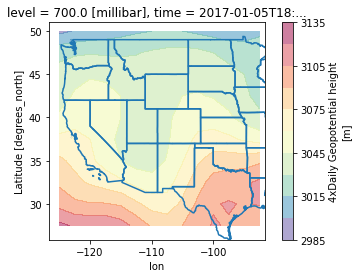

In [62]:
fig,ax = plt.subplots();
states_gdf.boundary.plot(ax=ax);
((xds_pressure['hgt'].sel(time='2017-01-05 18', level=700))).squeeze().plot.contourf(levels=10,ax=ax, alpha=0.5, cmap='Spectral_r');
ax.set_xlim(west_coords['xmin'], west_coords['xmax']);
ax.set_ylim(west_coords['ymin'], west_coords['ymax']);


In [63]:
def custom_plotfuncs(ds, fig, tt, *args, **kwargs):
    ax = fig.subplots()
    tickslabels=np.arange(2900,3210,10)
    norm=BoundaryNorm(tickslabels, len(tickslabels)-1)
    
    states_gdf.boundary.plot(ax=ax);
    da = ds['hgt'].isel(time=tt)
    # normalized_anomaly = np.sqrt(np.abs(mean_700mb.hgt.mean()**2 - da.mean()**2)).values
    pressure_plot_contour = da.squeeze().plot.contour(levels=20,
                                                        ax=ax, 
                                                        colors='k',);
    ax.clabel(pressure_plot_contour, inline=True, inline_spacing=-7, fontsize=10)
    pressure_plot = (da).squeeze().plot.contourf(levels=20,
                                                                                ax=ax, 
                                                                                alpha=0.8, 
                                                                                cmap='Spectral_r',
                                                                                extend='both',
                                                                                norm=norm,
                                                                                vmin=2900,
                                                                                vmax=3200);
    
    date = str(da.coords['time.date'].values)
    hour = str(da.coords['time.hour'].values)
    time_title = f'700mb Pressure \nDate: {date} Time: {hour} UTC'
    
    ax.set_xlim(west_coords['xmin'], west_coords['xmax']);
    ax.set_ylim(west_coords['ymin'], west_coords['ymax']);
    ax.set_title(time_title)
    return None, None

In [64]:
mov_custom = Movie(pressure_700mb.chunk({'time':1}),
                    custom_plotfuncs, 
                    input_check=False,
                    pixelwidth=800,
                    pixelheight=500,
                    dpi=60)

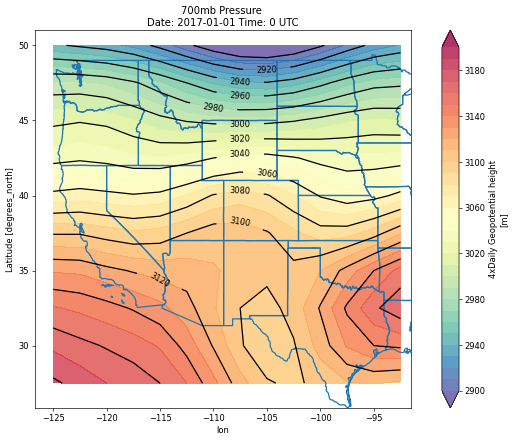

In [65]:
mov_custom.preview(0)

In [66]:
%%capture
mov_custom.save('/home/dlhogan/GitHub/sublimation_of_snow/misc/700mb_hgt_20170107.gif', 
                progress=True, 
                parallel=True, 
                overwrite_existing=True,
                remove_movie=False,
                framerate=5,
                gif_framerate=5,)

In [7]:
def psl_monolevel_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None, filter_data=True):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login
    ftp.cwd(f'./Datasets/NARR/{product}/')
    
    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')
    # Separate out pressure files that I'm interested in
    product_files = []
    for file in files:
        if (f'{product_code}.{start_year}' in file) or (f'{product_code}.{end_year}' in file):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/NARR/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            if filter_data:
                print(f'Filtering {file}...')
                # Transform coordiantes
                ds.coords['lon'] = ds.coords['lon'] - 180
                # Filter to western US
                ds = ds.sel(lat=slice(coords['ymax'], coords['ymin']), lon=slice(coords['xmin'], coords['xmax']))
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [16]:
pr_wtr_ds = psl_monolevel_dynamic_load('monolevel','pr_wtr','2018','2019', coords=west_coords, filter_data=False)

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching pr_wtr.2018.nc...


/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pr_wtr' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Done!
Fetching pr_wtr.2019.nc...


/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pr_wtr' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Done!


In [17]:
daily_pr_wtr_ds = pr_wtr_ds.groupby('time.date').mean()

In [18]:
pr_wtr_ltm_ds = psl_monolevel_dynamic_load('Derived/monolevel','pr_wtr','mon.ltm',None, coords=west_coords, filter_data=False)

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching pr_wtr.mon.ltm.nc...
Done!


/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/coding/times.py:123: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetim

In [19]:
%matplotlib inline

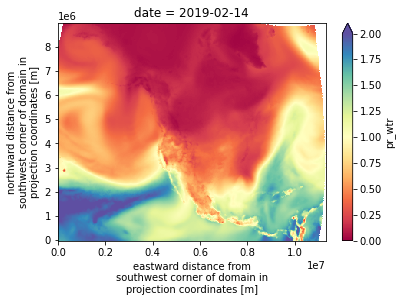

In [21]:

(daily_pr_wtr_ds.sel(date=dt.date(2019,2,14))['pr_wtr']*39.37/1000).plot(vmin=0,vmax=2, cmap='Spectral')

In [38]:
import cartopy
import cartopy.crs as ccrs
def custom_plotfuncs2(ds, fig, tt, *args, **kwargs):
    ax = fig.subplots()

    da = ds['pr_wtr'].isel(time=tt)
    globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
    lcc = ccrs.LambertConformal(globe=globe, false_easting=6.603e6, false_northing=3.1e6,)
    ax = plt.axes(projection=lcc)
    (da*39.37/1000).squeeze().plot(ax=ax, 
                        alpha=0.8, 
                        cmap='Spectral',
                        extend='both',
                        vmin=0,
                        vmax=2,
                        cbar_kwargs={'label':'Precipitable Water [in]'});
    
    ax.coastlines()
    date = str(da.coords['time.date'].values)
    hour = str(da.coords['time.hour'].values)
    time_title = f'Precipitable Water \nDate: {date} Hour: {hour} UTC'
    
    # ax.set_xlim(3e6, 7e6);
    # ax.set_ylim(.1e7, .6e7);
    ax.set_title(time_title)
    return None, None

In [46]:
#create movie object
mov =  Movie(pr_wtr_ds.sel(time=slice(dt.date(2018,11,22), dt.date(2018,12,1))).chunk({'time':1}),
                    custom_plotfuncs2, 
                    input_check=False,
                    pixelwidth=800,
                    pixelheight=500,
                    dpi=60)

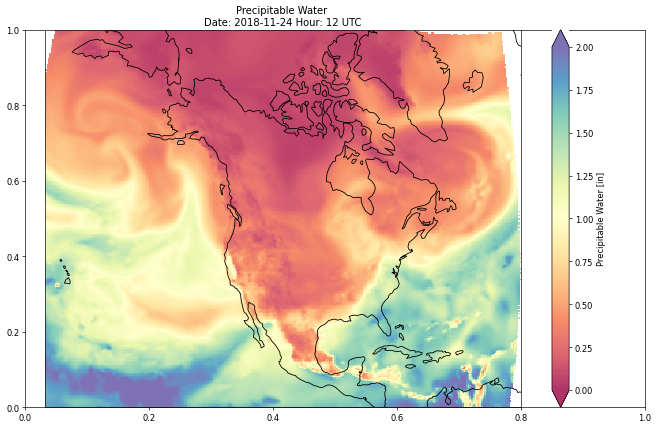

In [47]:
mov.preview(20)

In [48]:
%%capture
mov.save('/home/dlhogan/GitHub/sublimation_of_snow/misc/pr_wtr_112418.gif', 
                progress=True, 
                parallel=True, 
                overwrite_existing=True,
                remove_movie=False,
                framerate=5,
                gif_framerate=5,)